## Подготовка и анализ данных

* удаление или редакция пустых значений;
* работа с категориальными признаками;
* выявление взаимных связей;
* тестирование начальных гипотез


In [1]:
#visualization core
import matplotlib.pyplot as plt

#math core
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

Создадим функции для работы с текстовыми признаками:

In [2]:
def remove_digits_and_other(x):
    return ''.join(i for i in str(x) if not i.isdigit() and i not in ["/", ".", " "])

def remove_letters(x):
    return ''.join(i for i in str(x) if i.isdigit() and i not in ["/", ".", " ", ''])

In [3]:
df = pd.read_csv(r"C:\Users\Владислав\python\SPB_Butorin_python\titanic_train.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Массив содержит 10 атрибутов и 1 целевой признак - Survived.

Большая часть атрибутов числовые, к категориальным относястся - Name, Sex, Ticket, Cabin и Embarked

Вычислим процент отсутствующих значений:

In [6]:
df.isnull().sum() / len(df) *100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Большая часть значений (77%) для переменной Cabin отсуствует. Вероятно, эту переменную придется удалить...

Посмотрим на априорный шанс выживания:

<Axes: ylabel='count'>

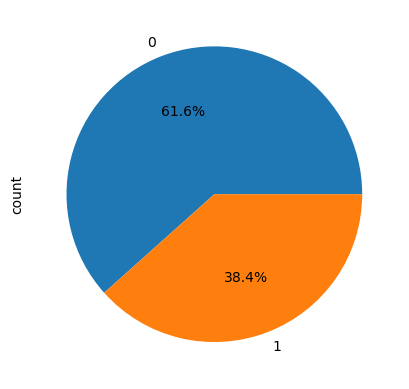

In [7]:
df.Survived.value_counts().plot.pie(autopct = '%.1f%%')

Модель, предсказывающая что никто не выжил, будет иметь точность (accuracy) около 62%. Соответсвенно, наша модель дожна работать лучше, иначе в ней не будет практического смысла

## Анализ целевой переменной

Изучим как меняется вероятность выживания, в зависимости от имеющихся факторов:

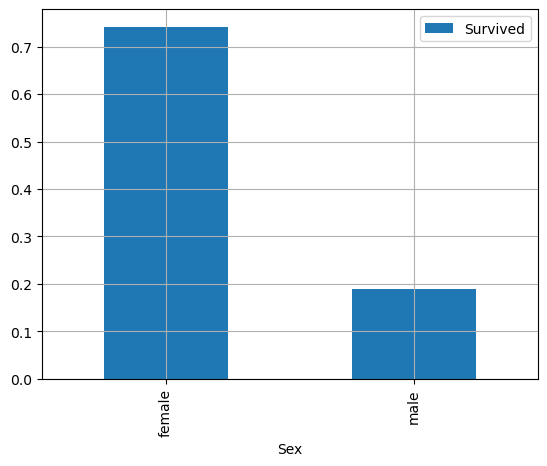

In [8]:
df[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar()
plt.grid()

Теперь посмотрим на статистику по классам каюты

<Axes: xlabel='Pclass'>

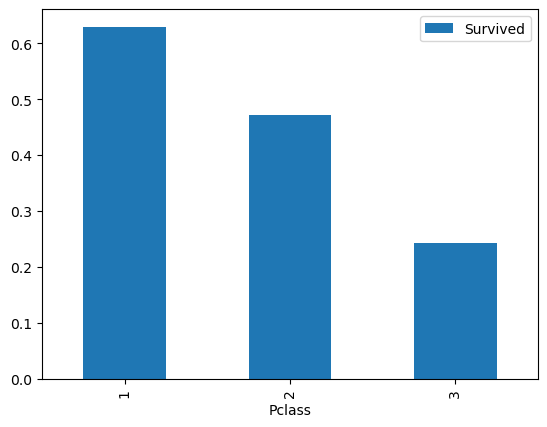

In [9]:
df[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()


Анализ среднего возраста:

<Axes: xlabel='Survived'>

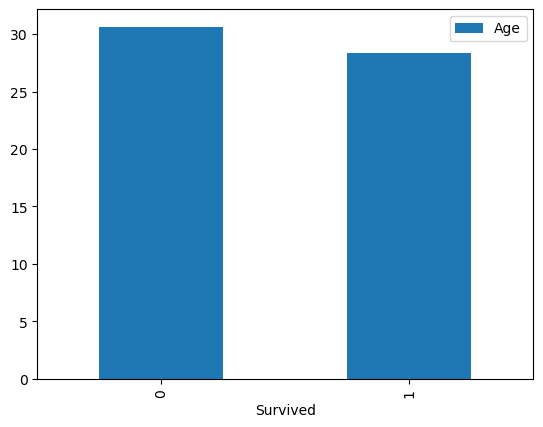

In [10]:
df[['Age','Survived']].groupby(['Survived']).mean().plot.bar()


Количество членов семьи неоднозначно влияет на выживаемость

<Axes: xlabel='Parch'>

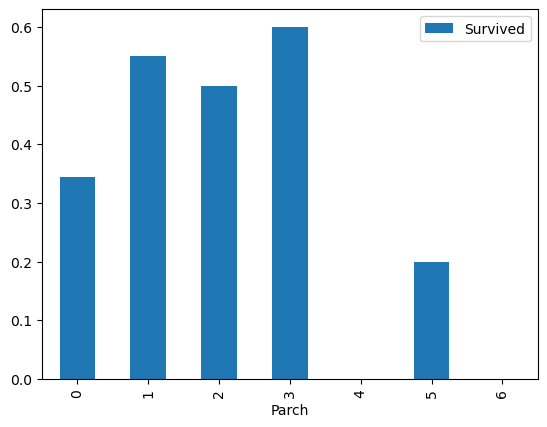

In [11]:
df[['Parch','Survived']].groupby(['Parch']).mean().plot.bar()


<Axes: xlabel='SibSp', ylabel='Parch'>

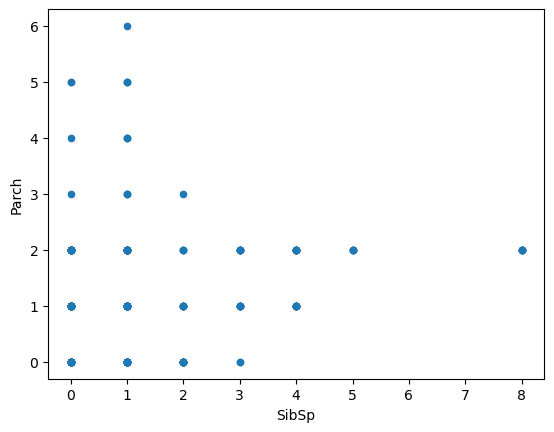

In [12]:
df.plot(kind='scatter', x='SibSp', y='Parch')

Рассмотрим как меняется целевая переменная в зависимости от стоимости билета:

<Axes: xlabel='Survived'>

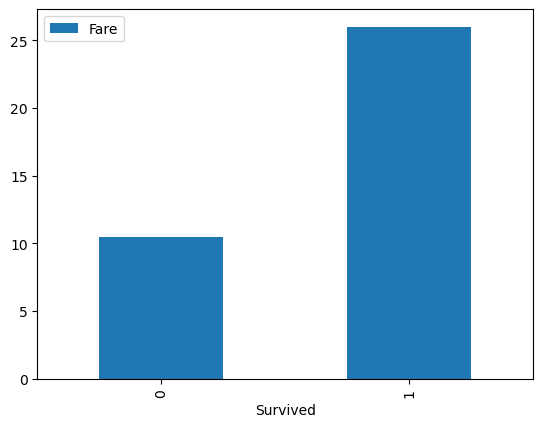

In [13]:
df[['Fare','Survived']].groupby(['Survived']).median().plot.bar()


Pclass
1    [[Axes(0.125,0.11;0.775x0.77)]]
2    [[Axes(0.125,0.11;0.775x0.77)]]
3    [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

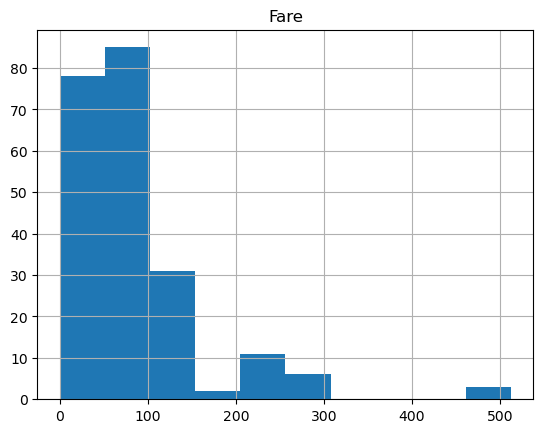

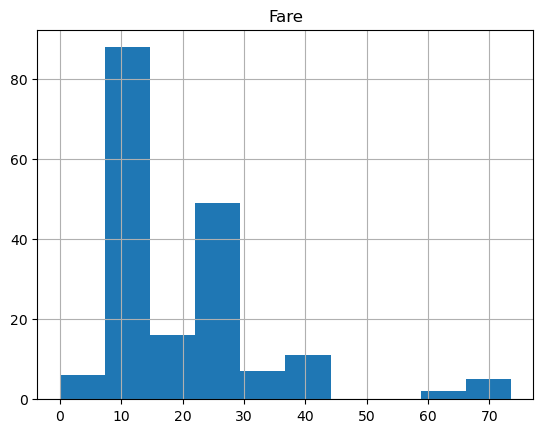

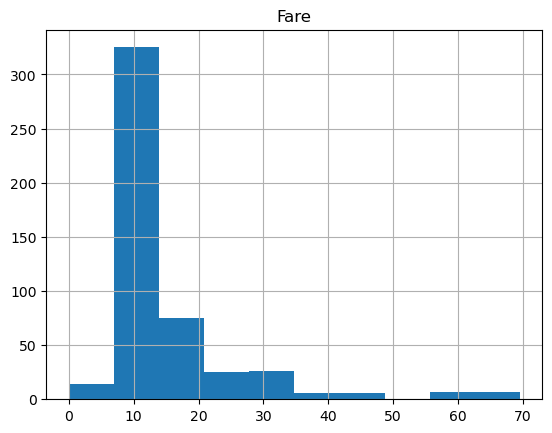

In [14]:
df[['Pclass', 'Fare']].groupby('Pclass').hist(['Fare'])

<Axes: xlabel='Embarked'>

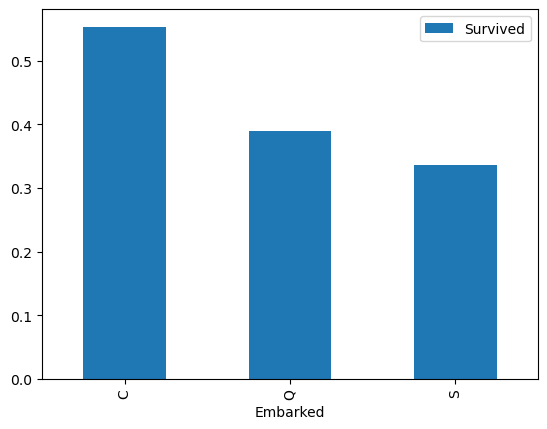

In [15]:
df[['Embarked', 'Survived']].groupby(['Embarked']).mean().plot.bar()

In [16]:
df[['Embarked', 'Survived']].groupby(['Embarked']).count() / len(df) * 100

,Survived
Embarked,
C,18.855219
Q,8.641975
S,72.278339


Место посадки показывает тренд с вероятностью выжить при крушении Титаника?

Таким образом, мы определили как известная информация о пассажирах связана с целевой переменной

## Преобразование переменных

Переменная Name содержит имена пассажиров...посмотрим, как мы можем использовать эту информацию

In [17]:
df.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [18]:
test = 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'

In [19]:
test.split()[1].split('.')[0]

'Mrs'

In [20]:
df['Name_cat'] = [i.split('.')[0] for i in [n.split()[1] for n in df.Name]]

In [21]:
len(df.Name_cat.unique())

31

In [22]:
df.Name_cat.value_counts()

Name_cat
Mr              502
Miss            179
Mrs             121
Master           40
Dr                7
Rev               6
y                 4
Planke,           3
Impe,             3
Gordon,           2
Col               2
Mlle              2
Major             2
Melkebeke,        1
Jonkheer          1
Shawah,           1
the               1
Velde,            1
Capt              1
Messemaeker,      1
Carlo,            1
Ms                1
Mme               1
Steen,            1
Mulder,           1
Pelsmaeker,       1
Walle,            1
der               1
Billiard,         1
Don               1
Cruyssen,         1
Name: count, dtype: int64

In [23]:
df[['Name_cat']].value_counts().reset_index().iloc[:5,0].tolist()

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']

In [24]:
# Выделим наиболее распространенные обращения (топ-5)
top_name = df[['Name_cat']].value_counts().reset_index().iloc[:5,0].tolist()

# Заменим редкие ображения на распространенные на основании пола
for i in range(df.shape[0]):
    if df.loc[i,'Name_cat'] not in top_name:
        if df.loc[i,'Sex'] == 'male':
            df.loc[i,'Name_cat'] = 'Mr'
        else:
            df.loc[i,'Name_cat'] = 'Miss'

<Axes: xlabel='Name_cat'>

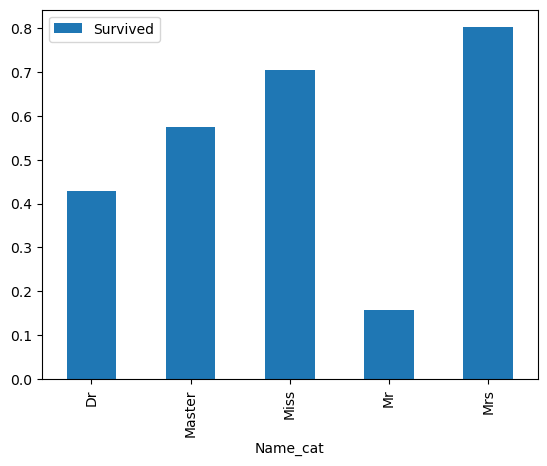

In [25]:
df[['Name_cat', 'Survived']].groupby(['Name_cat']).mean().plot.bar()

**Переменная Ticket содержит номер билета, попробуем изучить эту переменную**

In [26]:
df['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [27]:
df['Ticket_cor'] = df.Ticket.apply(remove_letters)
df.loc[(df['Ticket_cor']==''), ['Ticket_cor']] = '0'

df.Ticket_cor = df.Ticket_cor.astype(int)

<Axes: xlabel='Survived'>

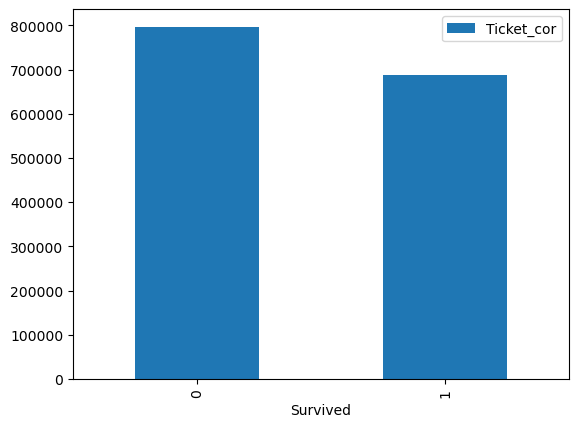

In [28]:
df[['Ticket_cor','Survived']].groupby(['Survived']).mean().plot.bar()


<Axes: ylabel='Frequency'>

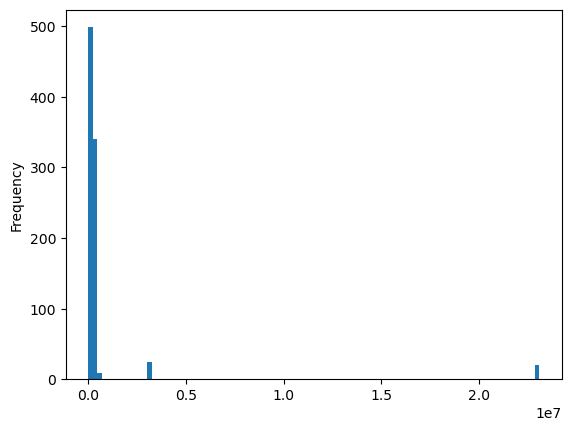

In [29]:
df.Ticket_cor.plot.hist(bins=100)

In [30]:
df['Ticket_cor'].mean() + 0.75*df['Ticket_cor'].std()

3323322.959723835

In [31]:
df[df['Ticket_cor'] > df['Ticket_cor'].mean() + 0.75*df['Ticket_cor'].std()].Ticket_cor.index

Index([  2, 115, 142, 173, 216, 243, 382, 400, 403, 414, 433, 579, 590, 636,
       664, 729, 744, 761, 816, 840],
      dtype='int64')

In [32]:
for i in df[df['Ticket_cor'] > df['Ticket_cor'].mean() + 0.75*df['Ticket_cor'].std()].Ticket_cor.index:
    df.loc[i, 'Ticket_cor'] = df['Ticket_cor'].mean()

<Axes: ylabel='Frequency'>

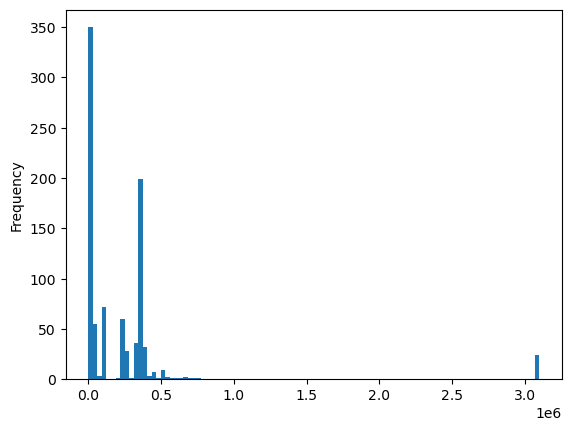

In [33]:
df.Ticket_cor.plot.hist(bins=100)

<Axes: xlabel='Survived'>

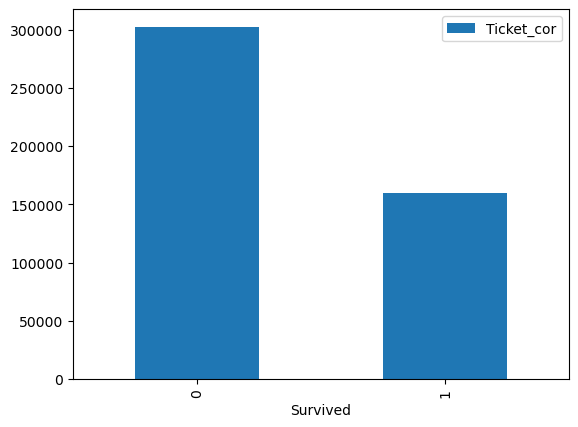

In [34]:
df[['Ticket_cor','Survived']].groupby(['Survived']).mean().plot.bar()

In [35]:
df[['Ticket_cor','Pclass']].corr()

,Ticket_cor,Pclass
Ticket_cor,1.00000,0.28995
Pclass,0.28995,1.00000


Разделение по номеру билета стало более значимым...

**Изучим переменную Age**

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Name_cat     891 non-null    object 
 13  Ticket_cor   891 non-null    float64
dtypes: float64(3), int64(5), object(6)
memory usage: 97.6+ KB


<Axes: ylabel='Frequency'>

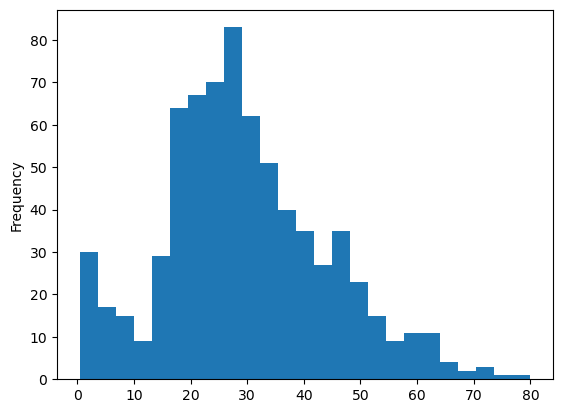

In [37]:
df.Age.dropna().plot.hist(bins=25)

In [38]:
df['Age_corrected'] = df['Age'].copy()

In [39]:
df[df['Age'].isnull()].Name_cat.value_counts()

Name_cat
Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: count, dtype: int64

<Axes: xlabel='Name_cat'>

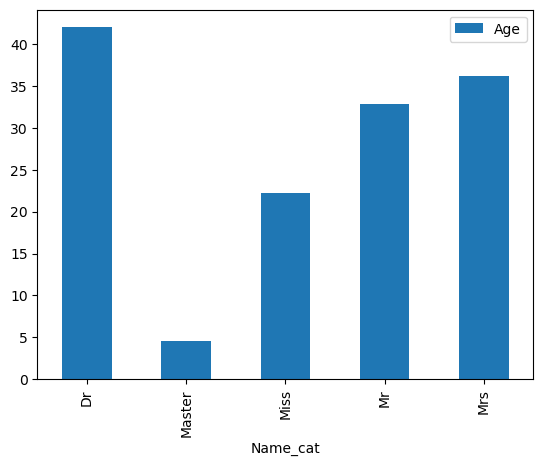

In [40]:
df[['Name_cat', 'Age']].groupby(['Name_cat']).mean().plot.bar()

Попробуем использовать информацию об обращении к человеку, для заполнения пустых значений возраста

In [41]:
df[df.Age.isnull()].Name_cat.value_counts()

Name_cat
Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: count, dtype: int64

Для каждой категории вычислим среднее и это значение используем для заполнения пропусков

In [42]:
for i in df.Name_cat.unique():
    df.loc[(df['Age'].isnull()) & (df['Name_cat']==i), 'Age_corrected'] = df[df['Name_cat']== i].Age.dropna().mean()

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Age_corrected'}>]], dtype=object)

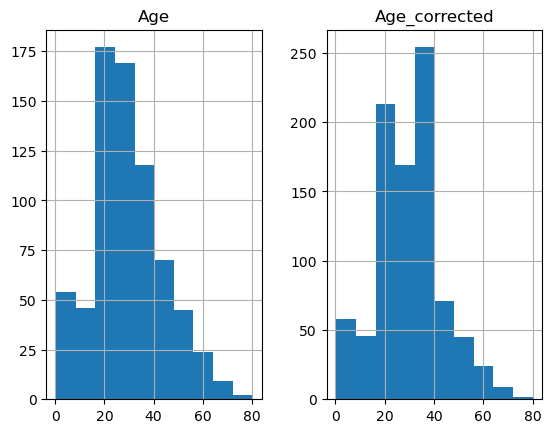

In [43]:
df[['Age', 'Age_corrected']].hist()

<Axes: ylabel='Frequency'>

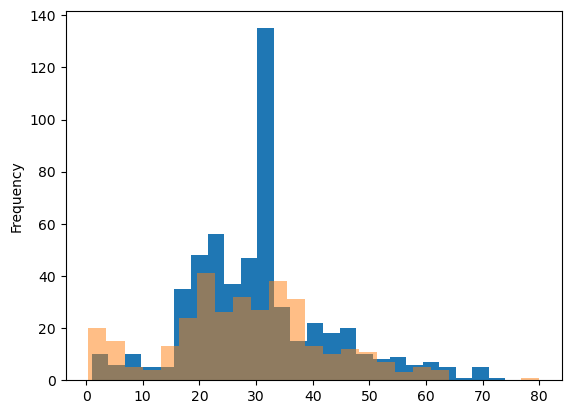

In [44]:
df[df['Survived']==0].Age_corrected.plot.hist(bins=25)
df[df['Survived']==1].Age_corrected.plot.hist(bins=25, alpha=0.5)

**Рассмотрим переменную Embarked - место посадки**

Southampton, Cherbourg, Queenstown.

In [45]:
df.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Заменим пустые значения на самое распространенное место посадки

In [46]:
for i in df[df.Embarked.isnull()].index:
    df.loc[i, 'Embarked'] = 'S'

<Axes: xlabel='Embarked'>

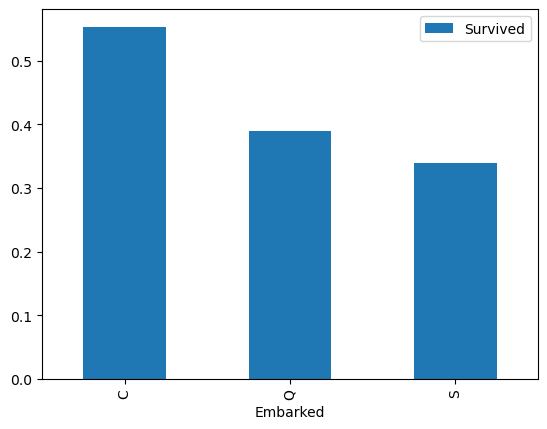

In [47]:
df[['Embarked','Survived']].groupby(['Embarked']).mean().plot.bar()

Существует некоторая закономерность, но она может быть также обучсловлена неравномерностью выборки (большинство пассажиров село в Саутгемптоне)

**Создадим переменную размер семьи**

In [48]:
df['Fam_size'] = df['SibSp'] + df['Parch'] 

<Axes: >

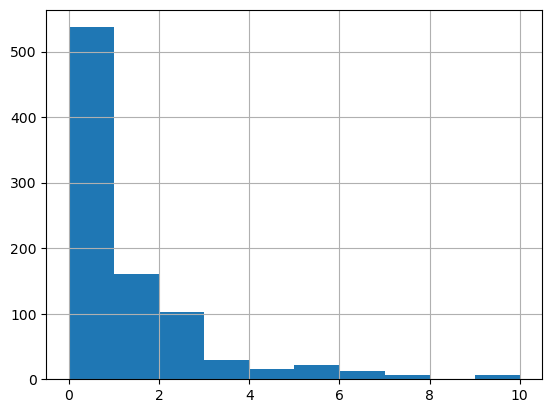

In [49]:
df.Fam_size.hist()

Распределение очень не равномерное, большинство имеет не более 2 членов семьи на борту

<Axes: xlabel='Fam_size'>

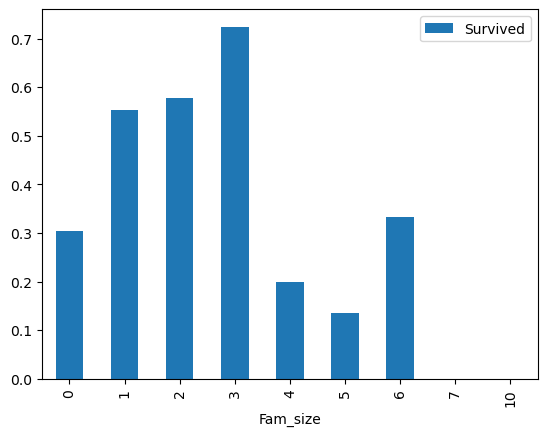

In [50]:
df[['Fam_size','Survived']].groupby(['Fam_size']).mean().plot.bar()

In [51]:
df.Fam_size.value_counts()

Fam_size
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64

Обрежем наше распределение на 3х членах семьи

In [52]:
for i in range(len(df)):
    if df.Fam_size[i] > 0:
        df.loc[i, 'Fam_size'] = 1
    else:
        df.loc[i, 'Fam_size'] = df.Fam_size[i]

<Axes: xlabel='Fam_size'>

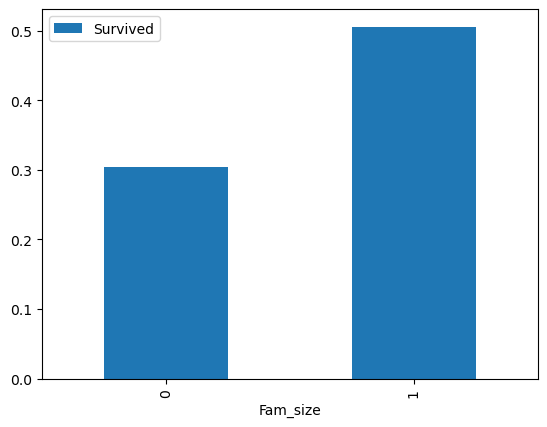

In [53]:
df[['Fam_size', 'Survived']].groupby(['Fam_size']).mean().plot.bar()

In [54]:
df.Fam_size.value_counts()

Fam_size
0    537
1    354
Name: count, dtype: int64

Распредление значений разбалансировано - значительное большинство ехало без членов семей. Возможно, лучше сделать два класса - 0 и 1

## Финальная подготовка данных

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       891 non-null    object 
 12  Name_cat       891 non-null    object 
 13  Ticket_cor     891 non-null    float64
 14  Age_corrected  891 non-null    float64
 15  Fam_size       891 non-null    int64  
dtypes: float64(4), int64(6), object(6)
memory usage: 111.5+ KB


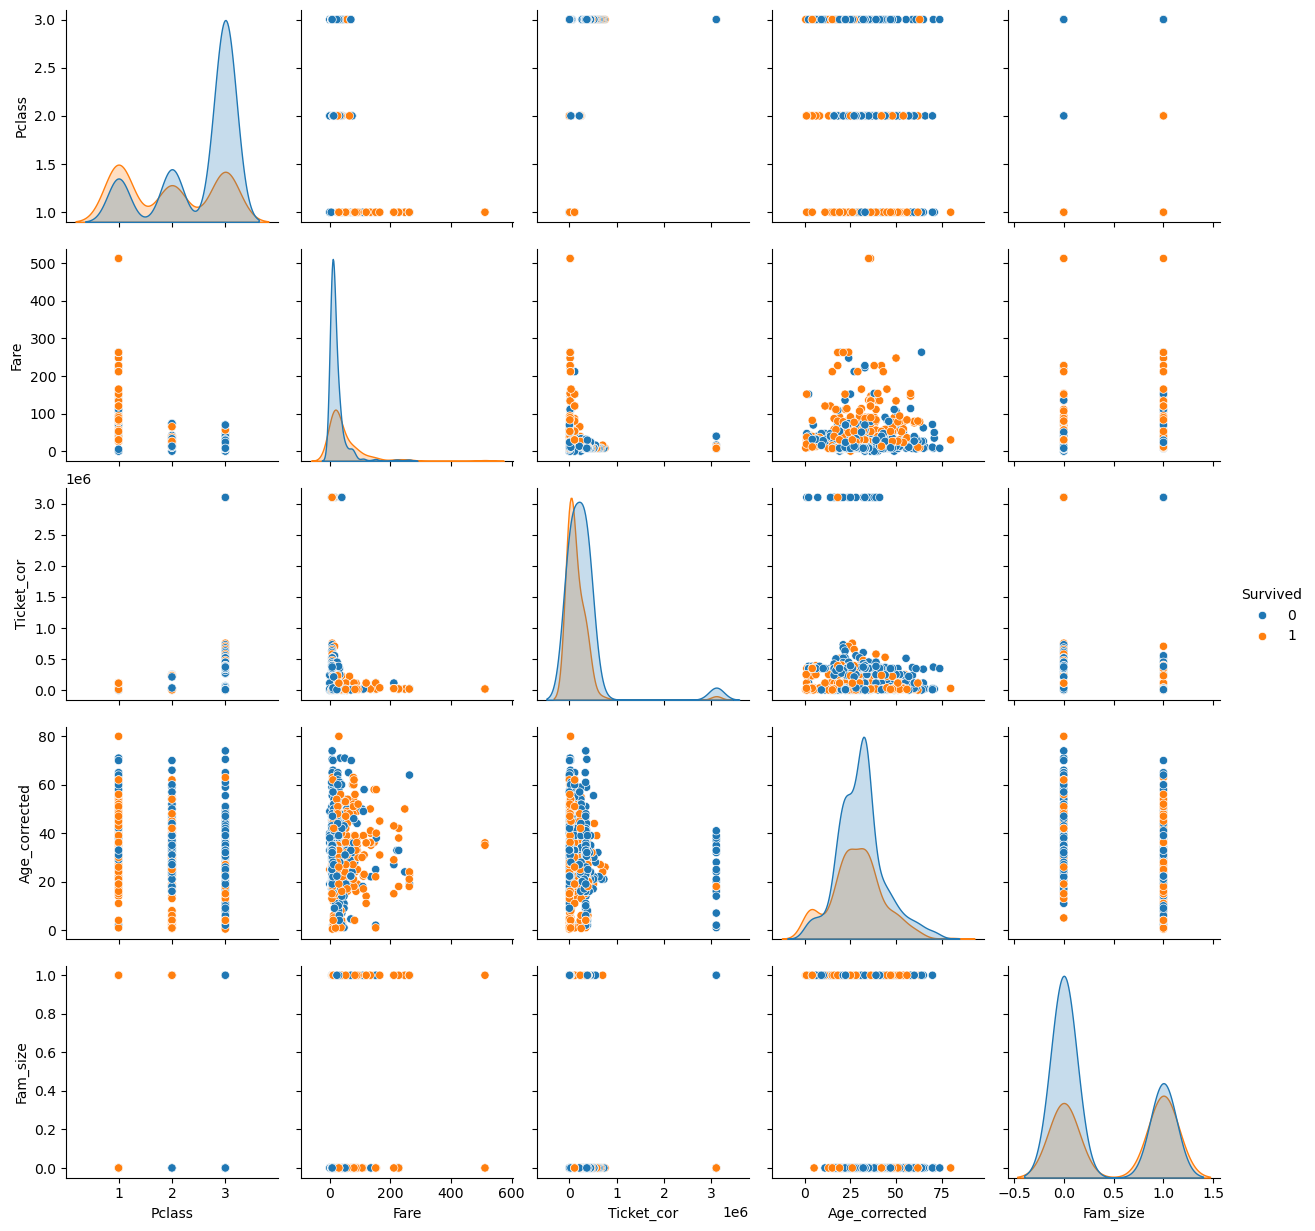

In [56]:
import seaborn as sns


sns.pairplot(df.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1),
             hue='Survived')

Разделим целевую переменную и атрибуты, по которым будет выполняться прогноз

In [57]:
X = df.drop(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
Y = df.Survived
X

,Pclass,Sex,Fare,Embarked,Name_cat,Ticket_cor,Age_corrected,Fam_size
0,3,male,7.2500,S,Mr,521171.000000,22.000000,1
1,1,female,71.2833,C,Mrs,17599.000000,38.000000,1
2,3,female,7.9250,S,Miss,754682.722783,26.000000,0
3,1,female,53.1000,S,Mrs,113803.000000,35.000000,1
4,3,male,8.0500,S,Mr,373450.000000,35.000000,0
...,...,...,...,...,...,...,...,...
886,2,male,13.0000,S,Mr,211536.000000,27.000000,0
887,1,female,30.0000,S,Miss,112053.000000,19.000000,0
888,3,female,23.4500,S,Miss,6607.000000,22.269231,1
889,1,male,30.0000,C,Mr,111369.000000,26.000000,0


In [58]:
X['Sex'] = pd.get_dummies(X['Sex']).drop(['female'], axis=1)
X['Embarked'] = X['Embarked'].astype('category').cat.codes
X['Name_cat'] = X['Name_cat'].astype('category').cat.codes

X

,Pclass,Sex,Fare,Embarked,Name_cat,Ticket_cor,Age_corrected,Fam_size
0,3,True,7.2500,2,3,521171.000000,22.000000,1
1,1,False,71.2833,0,4,17599.000000,38.000000,1
2,3,False,7.9250,2,2,754682.722783,26.000000,0
3,1,False,53.1000,2,4,113803.000000,35.000000,1
4,3,True,8.0500,2,3,373450.000000,35.000000,0
...,...,...,...,...,...,...,...,...
886,2,True,13.0000,2,3,211536.000000,27.000000,0
887,1,False,30.0000,2,2,112053.000000,19.000000,0
888,3,False,23.4500,2,2,6607.000000,22.269231,1
889,1,True,30.0000,0,3,111369.000000,26.000000,0


# ML

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size= 0.75, random_state = 42)

In [60]:
clf = DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state = 1)
clf = clf.fit(x_train, y_train)

rfc = RandomForestClassifier(max_depth=9, criterion='gini', random_state = 1)
rfc = rfc.fit(x_train, y_train)

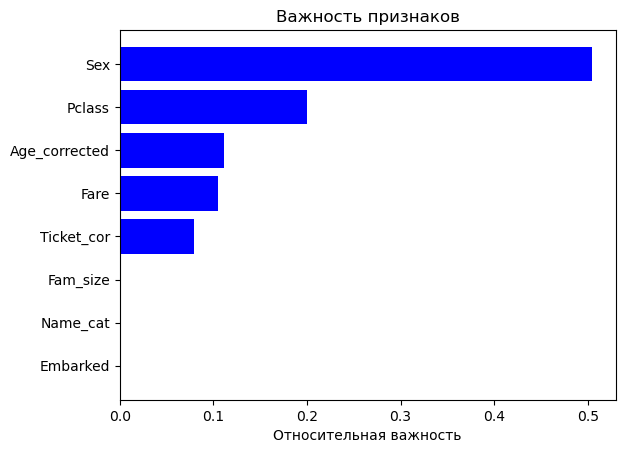

In [61]:
importances = clf.feature_importances_
features = x_train.columns
# Добавление сортировки по важности
indices = np.argsort(importances)

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

In [62]:
predict = clf.predict(x_test)
predict_rfc = rfc.predict(x_test)

In [63]:
# для дерева решений
accuracy_score(y_test, predict)

0.8161434977578476

In [64]:
# для случайного леса
accuracy_score(y_test, predict_rfc)

0.852017937219731